# Feature Engineering
## Diabetes Risk & Insulin Management System

This notebook performs feature engineering including:
- Creating interaction features
- Rolling window statistics
- Domain-specific features
- Feature scaling
- Feature selection


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys

# Add parent directory to path
sys.path.insert(0, str(Path().resolve().parent))

from src.utils.config import (
    DATA_CLEAN, DATA_SCALED, ENGINEERED_PATH, FINAL_FEATURES,
    TARGET, PATIENT_ID_COL, NUMERIC_COLS_TO_SCALE
)

warnings.filterwarnings('ignore')
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load Cleaned Data


In [2]:
# Load cleaned data
df = pd.read_csv(DATA_CLEAN)

print(f"Cleaned data shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()


Cleaned data shape: (535, 24)

Columns: ['Patient_ID', 'Glucose_Level', 'Heart_Rate', 'Activity_Level', 'Calories_Burned', 'Sleep_Duration', 'Step_Count', 'Insulin_Dose', 'Medication_Intake', 'Diet_Quality_Score', 'Stress_Level', 'BMI', 'HbA1c', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic', 'Predicted_Progression', 'Timestamp_hour', 'Timestamp_dow', 'Timestamp_month', 'Timestamp_is_weekend', 'Timestamp_ts', 'Timestamp_sin_hour', 'Timestamp_cos_hour', 'time_delta_hours']


,Patient_ID,Glucose_Level,Heart_Rate,Activity_Level,Calories_Burned,Sleep_Duration,Step_Count,Insulin_Dose,Medication_Intake,Diet_Quality_Score,...,Blood_Pressure_Diastolic,Predicted_Progression,Timestamp_hour,Timestamp_dow,Timestamp_month,Timestamp_is_weekend,Timestamp_ts,Timestamp_sin_hour,Timestamp_cos_hour,time_delta_hours
0,P001,98.2,62.0,8,165.4,8.7,1266,2,1,3,...,72,0,22,1,6,0,1749593700,-0.500000,0.866025,0.00
1,P001,176.4,62.0,9,230.8,4.5,8614,2,1,10,...,86,0,14,3,6,0,1749738600,-0.500000,-0.866025,40.25
2,P001,168.8,92.0,10,249.1,5.6,5220,8,0,10,...,99,2,0,5,6,1,1749861000,0.000000,1.000000,34.00
3,P001,115.0,82.0,9,152.8,6.1,1275,6,1,2,...,66,0,21,0,6,0,1750108500,-0.707107,0.707107,48.00
4,P001,118.8,67.0,10,204.5,9.0,4087,2,1,8,...,79,0,7,5,7,1,1752305400,0.965926,-0.258819,48.00


## 2. Create Interaction Features


In [3]:
# Create interaction features
print("=" * 60)
print("CREATING INTERACTION FEATURES")
print("=" * 60)

# Sort for rolling windows
if PATIENT_ID_COL in df.columns and 'Timestamp_ts' in df.columns:
    df = df.sort_values([PATIENT_ID_COL, 'Timestamp_ts']).reset_index(drop=True)

# 1. Stress × Sleep interaction
if 'Stress_Level' in df.columns and 'Sleep_Duration' in df.columns:
    df['Stress_x_Sleep'] = df['Stress_Level'] * df['Sleep_Duration']
    print("Created: Stress_x_Sleep")

# 2. Glucose-to-HbA1c ratio
if 'Glucose_Level' in df.columns and 'HbA1c' in df.columns:
    df['Glucose_to_HbA1c'] = df['Glucose_Level'] / (df['HbA1c'] + 1e-6)
    print("Created: Glucose_to_HbA1c")

# 3. BP ratio
if 'Blood_Pressure_Systolic' in df.columns and 'Blood_Pressure_Diastolic' in df.columns:
    df['BP_ratio'] = df['Blood_Pressure_Systolic'] / (df['Blood_Pressure_Diastolic'] + 1e-6)
    print("Created: BP_ratio")

# 4. Activity efficiency
if 'Step_Count' in df.columns and 'Activity_Level' in df.columns:
    df['Step_intensity'] = df['Step_Count'] / (df['Activity_Level'] + 1)
    print("Created: Step_intensity")

# 5. Sleep efficiency
if 'Sleep_Duration' in df.columns:
    df['Sleep_efficiency'] = df['Sleep_Duration'] / 24.0
    print("Created: Sleep_efficiency")

print(f"\nTotal features after interactions: {len(df.columns)}")


CREATING INTERACTION FEATURES
Created: Stress_x_Sleep
Created: Glucose_to_HbA1c
Created: BP_ratio
Created: Step_intensity
Created: Sleep_efficiency

Total features after interactions: 29


## 3. Create Rolling Window Statistics


In [4]:
# Create rolling window statistics
print("=" * 60)
print("CREATING ROLLING WINDOW STATISTICS")
print("=" * 60)

if PATIENT_ID_COL in df.columns:
    # Glucose variability (3-record rolling std)
    if 'Glucose_Level' in df.columns:
        df['Glucose_std_3'] = (
            df.groupby(PATIENT_ID_COL)['Glucose_Level']
              .transform(lambda x: x.rolling(window=3, min_periods=1).std())
        )
        print("Created: Glucose_std_3 (3-record rolling std)")
    
    # Glucose mean (3-record rolling mean)
    if 'Glucose_Level' in df.columns:
        df['Glucose_mean_3'] = (
            df.groupby(PATIENT_ID_COL)['Glucose_Level']
              .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
        )
        print("Created: Glucose_mean_3 (3-record rolling mean)")
    
    # Heart rate variability
    if 'Heart_Rate' in df.columns:
        df['Heart_Rate_std_3'] = (
            df.groupby(PATIENT_ID_COL)['Heart_Rate']
              .transform(lambda x: x.rolling(window=3, min_periods=1).std())
        )
        print("Created: Heart_Rate_std_3 (3-record rolling std)")

print(f"\nTotal features after rolling stats: {len(df.columns)}")


CREATING ROLLING WINDOW STATISTICS
Created: Glucose_std_3 (3-record rolling std)
Created: Glucose_mean_3 (3-record rolling mean)
Created: Heart_Rate_std_3 (3-record rolling std)

Total features after rolling stats: 32


## 4. Feature Scaling


FEATURE SCALING
Features to scale: 29
Features: ['Glucose_Level', 'Heart_Rate', 'Activity_Level', 'Calories_Burned', 'Sleep_Duration', 'Step_Count', 'Medication_Intake', 'Diet_Quality_Score', 'Stress_Level', 'BMI']...

Scaler saved to: ..\models\scaler.pkl
Scaled data saved to: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\data\scaled_data\scaled_features.csv


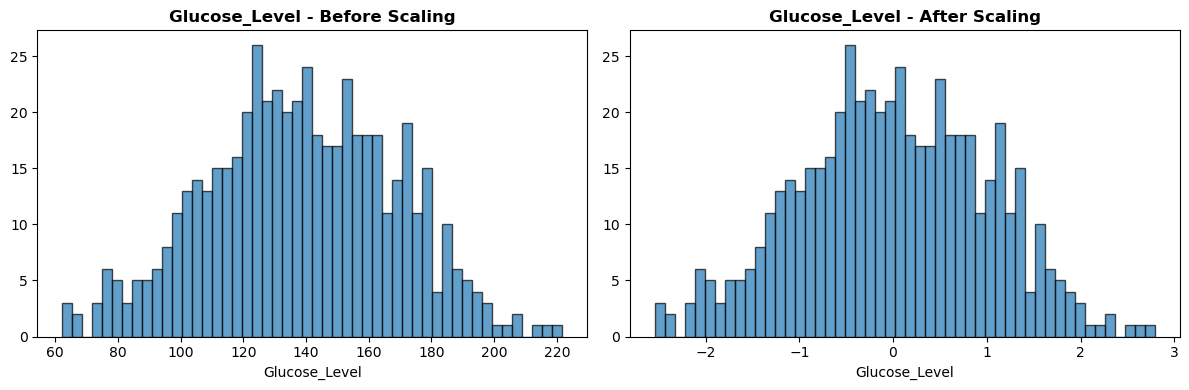

In [5]:
# Feature scaling
print("=" * 60)
print("FEATURE SCALING")
print("=" * 60)

from sklearn.preprocessing import StandardScaler
import pickle

# Get features to scale (exclude target and ID columns)
exclude_cols = [TARGET, PATIENT_ID_COL, 'Timestamp_ts', 'timestamp_sorted']
features_to_scale = [col for col in NUMERIC_COLS_TO_SCALE 
                     if col in df.columns and col not in exclude_cols]

# Also include engineered features that are numeric
engineered_features = [col for col in df.columns 
                      if col not in exclude_cols + features_to_scale 
                      and df[col].dtype in [np.float64, np.int64]
                      and col != TARGET]

features_to_scale = features_to_scale + engineered_features

print(f"Features to scale: {len(features_to_scale)}")
print(f"Features: {features_to_scale[:10]}...")  # Show first 10

# Apply scaling
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Save scaler
scaler_path = Path('../models/scaler.pkl')
scaler_path.parent.mkdir(parents=True, exist_ok=True)
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"\nScaler saved to: {scaler_path}")

# Save scaled data
DATA_SCALED.parent.mkdir(parents=True, exist_ok=True)
df_scaled.to_csv(DATA_SCALED, index=False)
print(f"Scaled data saved to: {DATA_SCALED}")

# Show before/after comparison
if len(features_to_scale) > 0:
    sample_feature = features_to_scale[0]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(df[sample_feature].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'{sample_feature} - Before Scaling', fontweight='bold')
    axes[0].set_xlabel(sample_feature)
    
    axes[1].hist(df_scaled[sample_feature].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title(f'{sample_feature} - After Scaling', fontweight='bold')
    axes[1].set_xlabel(sample_feature)
    
    plt.tight_layout()
    plt.show()

df = df_scaled.copy()


## 5. Feature Selection


FEATURE SELECTION

Top 20 features by correlation with Insulin_Dose:
 1. Glucose_std_3                 : 0.0993
 2. Step_intensity                : 0.0639
 3. Activity_Level                : 0.0540
 4. time_delta_hours              : 0.0507
 5. Glucose_Level                 : 0.0487
 6. Sleep_efficiency              : 0.0473
 7. Sleep_Duration                : 0.0473
 8. Predicted_Progression         : 0.0455
 9. Medication_Intake             : 0.0440
10. BMI                           : 0.0433
11. Glucose_to_HbA1c              : 0.0415
12. Calories_Burned               : 0.0372
13. Stress_Level                  : 0.0350
14. Diet_Quality_Score            : 0.0329
15. Timestamp_dow                 : 0.0310
16. Timestamp_cos_hour            : 0.0301
17. HbA1c                         : 0.0206
18. Timestamp_month               : 0.0205
19. Timestamp_sin_hour            : 0.0200
20. BP_ratio                      : 0.0187


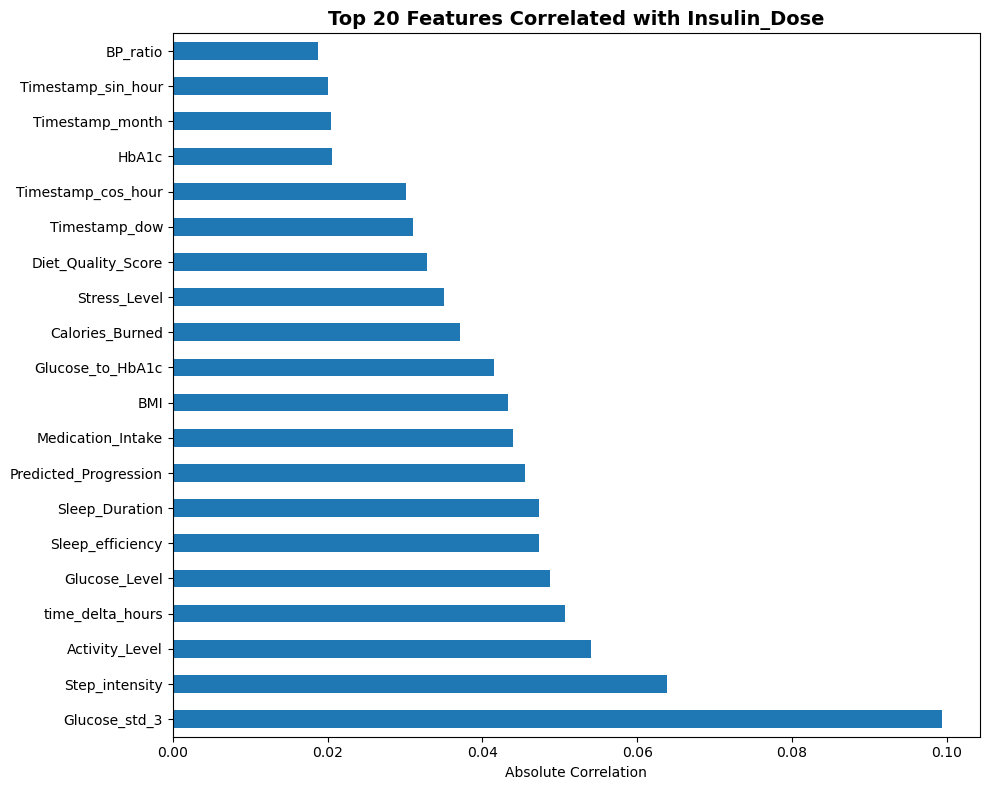


Selected 20 features
Final dataset shape: (535, 22)

Selected features saved to: C:\Users\Dell\Machine_Learning\Insulin_system\Diabetes_Risk_Isulin_Management_System\data\selected\selected_features.csv
Feature list saved to: ..\models\selected_features.txt


In [6]:
# Feature selection based on correlation with target
print("=" * 60)
print("FEATURE SELECTION")
print("=" * 60)

if TARGET in df.columns:
    # Calculate correlations
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude_from_selection = [TARGET, PATIENT_ID_COL, 'Timestamp_ts', 'timestamp_sorted']
    feature_cols = [col for col in numeric_cols if col not in exclude_from_selection]
    
    correlations = df[feature_cols + [TARGET]].corr()[TARGET].abs().sort_values(ascending=False)
    correlations = correlations.drop(TARGET)
    
    # Select top features
    top_k = 20  # Select top 20 features
    top_features = correlations.head(top_k).index.tolist()
    
    print(f"\nTop {top_k} features by correlation with {TARGET}:")
    for i, (feat, corr) in enumerate(correlations.head(top_k).items(), 1):
        print(f"{i:2d}. {feat:30s}: {corr:.4f}")
    
    # Visualize
    plt.figure(figsize=(10, max(8, len(top_features) * 0.4)))
    correlations.head(top_k).plot(kind='barh')
    plt.title(f'Top {top_k} Features Correlated with {TARGET}', fontsize=14, fontweight='bold')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.show()
    
    # Create final dataset with selected features
    selected_cols = [PATIENT_ID_COL] + top_features + [TARGET] if PATIENT_ID_COL in df.columns else top_features + [TARGET]
    selected_cols = [col for col in selected_cols if col in df.columns]
    
    df_selected = df[selected_cols].copy()
    
    print(f"\nSelected {len(top_features)} features")
    print(f"Final dataset shape: {df_selected.shape}")
    
    # Save selected features
    FINAL_FEATURES.parent.mkdir(parents=True, exist_ok=True)
    df_selected.to_csv(FINAL_FEATURES, index=False)
    print(f"\nSelected features saved to: {FINAL_FEATURES}")
    
    # Save feature list
    feature_list_path = Path('../models/selected_features.txt')
    with open(feature_list_path, 'w') as f:
        f.write('\n'.join(top_features))
    print(f"Feature list saved to: {feature_list_path}")
    
    df = df_selected.copy()
else:
    print(f"Target variable '{TARGET}' not found!")


## 6. Feature Engineering Summary


In [7]:
# Summary
print("=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)

print(f"\nFinal dataset shape: {df.shape}")
print(f"Features: {len(df.columns) - 1} (excluding target)")
print(f"Target: {TARGET}")

print("\nFinal features:")
for i, col in enumerate(df.columns, 1):
    if col != TARGET:
        print(f"  {i:2d}. {col}")

print("\n" + "=" * 60)
print("Feature engineering completed!")
print("=" * 60)


FEATURE ENGINEERING SUMMARY

Final dataset shape: (535, 22)
Features: 21 (excluding target)
Target: Insulin_Dose

Final features:
   1. Patient_ID
   2. Glucose_std_3
   3. Step_intensity
   4. Activity_Level
   5. time_delta_hours
   6. Glucose_Level
   7. Sleep_efficiency
   8. Sleep_Duration
   9. Predicted_Progression
  10. Medication_Intake
  11. BMI
  12. Glucose_to_HbA1c
  13. Calories_Burned
  14. Stress_Level
  15. Diet_Quality_Score
  16. Timestamp_dow
  17. Timestamp_cos_hour
  18. HbA1c
  19. Timestamp_month
  20. Timestamp_sin_hour
  21. BP_ratio

Feature engineering completed!
